In [5]:
import pyxdf
import PyQt5
import mne
import numpy as np
import pathlib
import mne
import pickle
import matplotlib
import matplotlib.pyplot as plt
# For interactive plots
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'qt')
from subfunctions import *

In [41]:
fname = 'Omri_Recording_001'
current_path = pathlib.Path().absolute()  
data_fname = current_path /'Data'/f'{fname}.xdf'

raw,events = read_xdf(fname = data_fname)
raw = add_annot(raw, events)

2 streams loaded
Creating RawArray with float64 data, n_channels=13, n_times=55805
    Range : 0 ... 55804 =      0.000 ...   446.432 secs
Ready.


## Prepro

In [3]:
raw.filter(l_freq=0.5,h_freq=None)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 825 samples (6.600 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.0s finished


<RawArray | 13 x 55805 (446.4 s), ~5.6 MB, data loaded>

Using matplotlib as 2D backend.


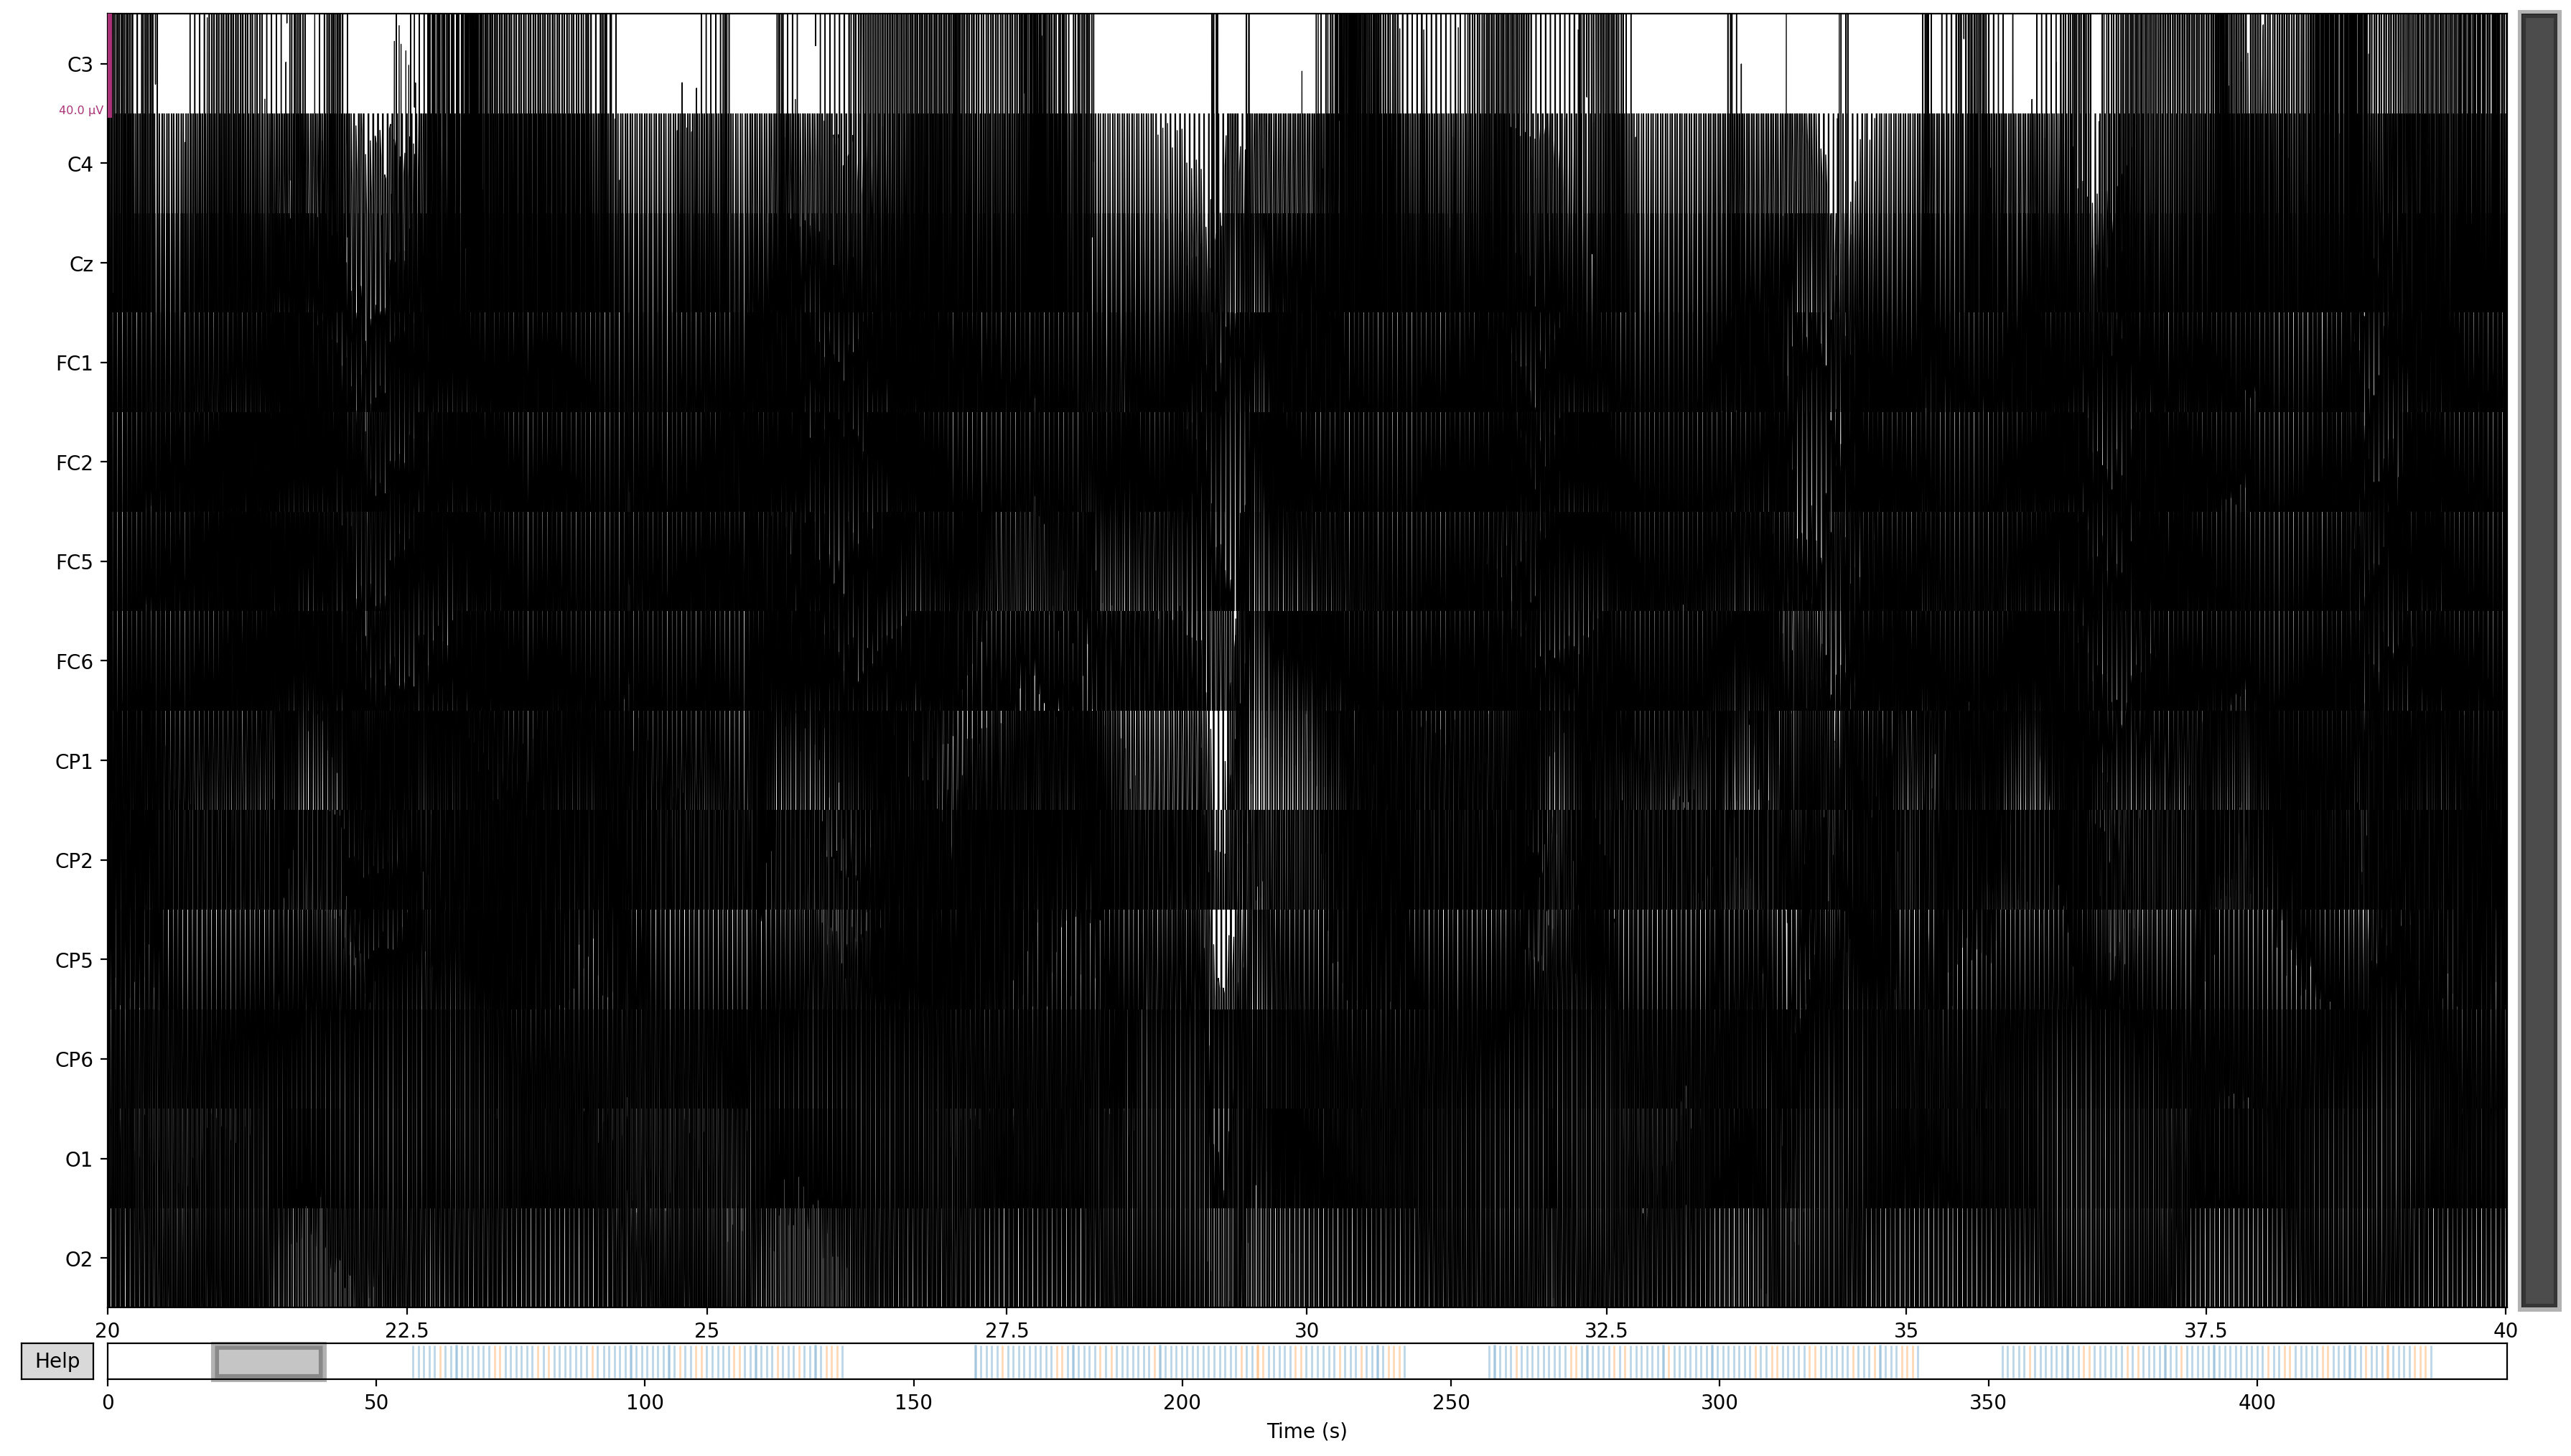

Channels marked as bad:
['C4', 'C3', 'O1']


In [4]:
raw.plot(duration=20,start=20)

In [7]:
raw.drop_channels(raw.info['bads'])

<RawArray | 10 x 55805 (446.4 s), ~4.3 MB, data loaded>

## Notch filter

In [ ]:
raw.notch_filter(freqs=[25,50])

## Epoching

In [16]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events_from_annot, tmin=-0.2, tmax=0.5, event_id=event_dict,detrend=0,baseline= (-0.2,0),preload=True)



Used Annotations descriptions: ['Standard Trial', 'Target Trial']
Not setting metadata
320 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 320 events and 88 original time points ...
0 bad epochs dropped


#### Reject bad epochs

In [ ]:
epochs.plot()


In [ ]:
epochs.save(current_path /'Data'/ f'{fname}_ep_rejected.xdf')

### ICA

In [49]:
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)

ica = ICA(n_components=epochs.info['nchan'], max_iter='auto', random_state=97)
ica.fit(epochs)
ica

Fitting ICA to data using 7 channels (please be patient, this may take a while)
Selecting by number: 7 components
Fitting ICA took 0.1s.


/var/folders/10/8b2yhzhd2c360q83nm9l57740000gn/T/ipykernel_36498/3880550274.py:5: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Method,fastica
Fit,17 iterations on epochs (24376 samples)
ICA components,7
Available PCA components,7
Channel types,eeg
ICA components marked for exclusion,—


In [55]:
ica.plot_components(inst = epochs)

[<MNEFigure size 1950x992 with 7 Axes>]

In [60]:
epochs_ica = epochs.copy()
ica.apply(epochs_ica)

Applying ICA to Epochs instance
    Transforming to ICA space (7 components)
    Zeroing out 3 ICA components
    Projecting back using 7 PCA components


/var/folders/10/8b2yhzhd2c360q83nm9l57740000gn/T/ipykernel_36498/3936925514.py:2: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  ica.apply(epochs_ica)


Number of events,277
Events,Standard Trial: 220Target Trial: 57
Time range,-0.200 – 0.496 sec
Baseline,-0.200 – 0.000 sec


In [7]:
processed_file_name = 'Or_1304'
current_path = pathlib.Path().absolute()  
data_fname = current_path /'Data'/'Processed Data'/ (processed_file_name + '_Processed.fif')
epochs = mne.read_epochs(data_fname)
epochs

Reading c:\Users\user\Documents\BCI_ALS\BCI_ALS\Data\Processed Data\Or_1304_Processed.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
687 matching events found
No baseline correction applied
0 projection items activated


C:\Users\user\AppData\Local\Temp\ipykernel_13844\4213684950.py:4: RuntimeWarning: This filename (c:\Users\user\Documents\BCI_ALS\BCI_ALS\Data\Processed Data\Or_1304_Processed.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(data_fname)


Number of events,687
Events,Standard Trial: 585Target Trial: 102
Time range,-0.200 – 0.496 sec
Baseline,-0.200 – 0.000 sec


## Plot Epochs

Using matplotlib as 2D backend.


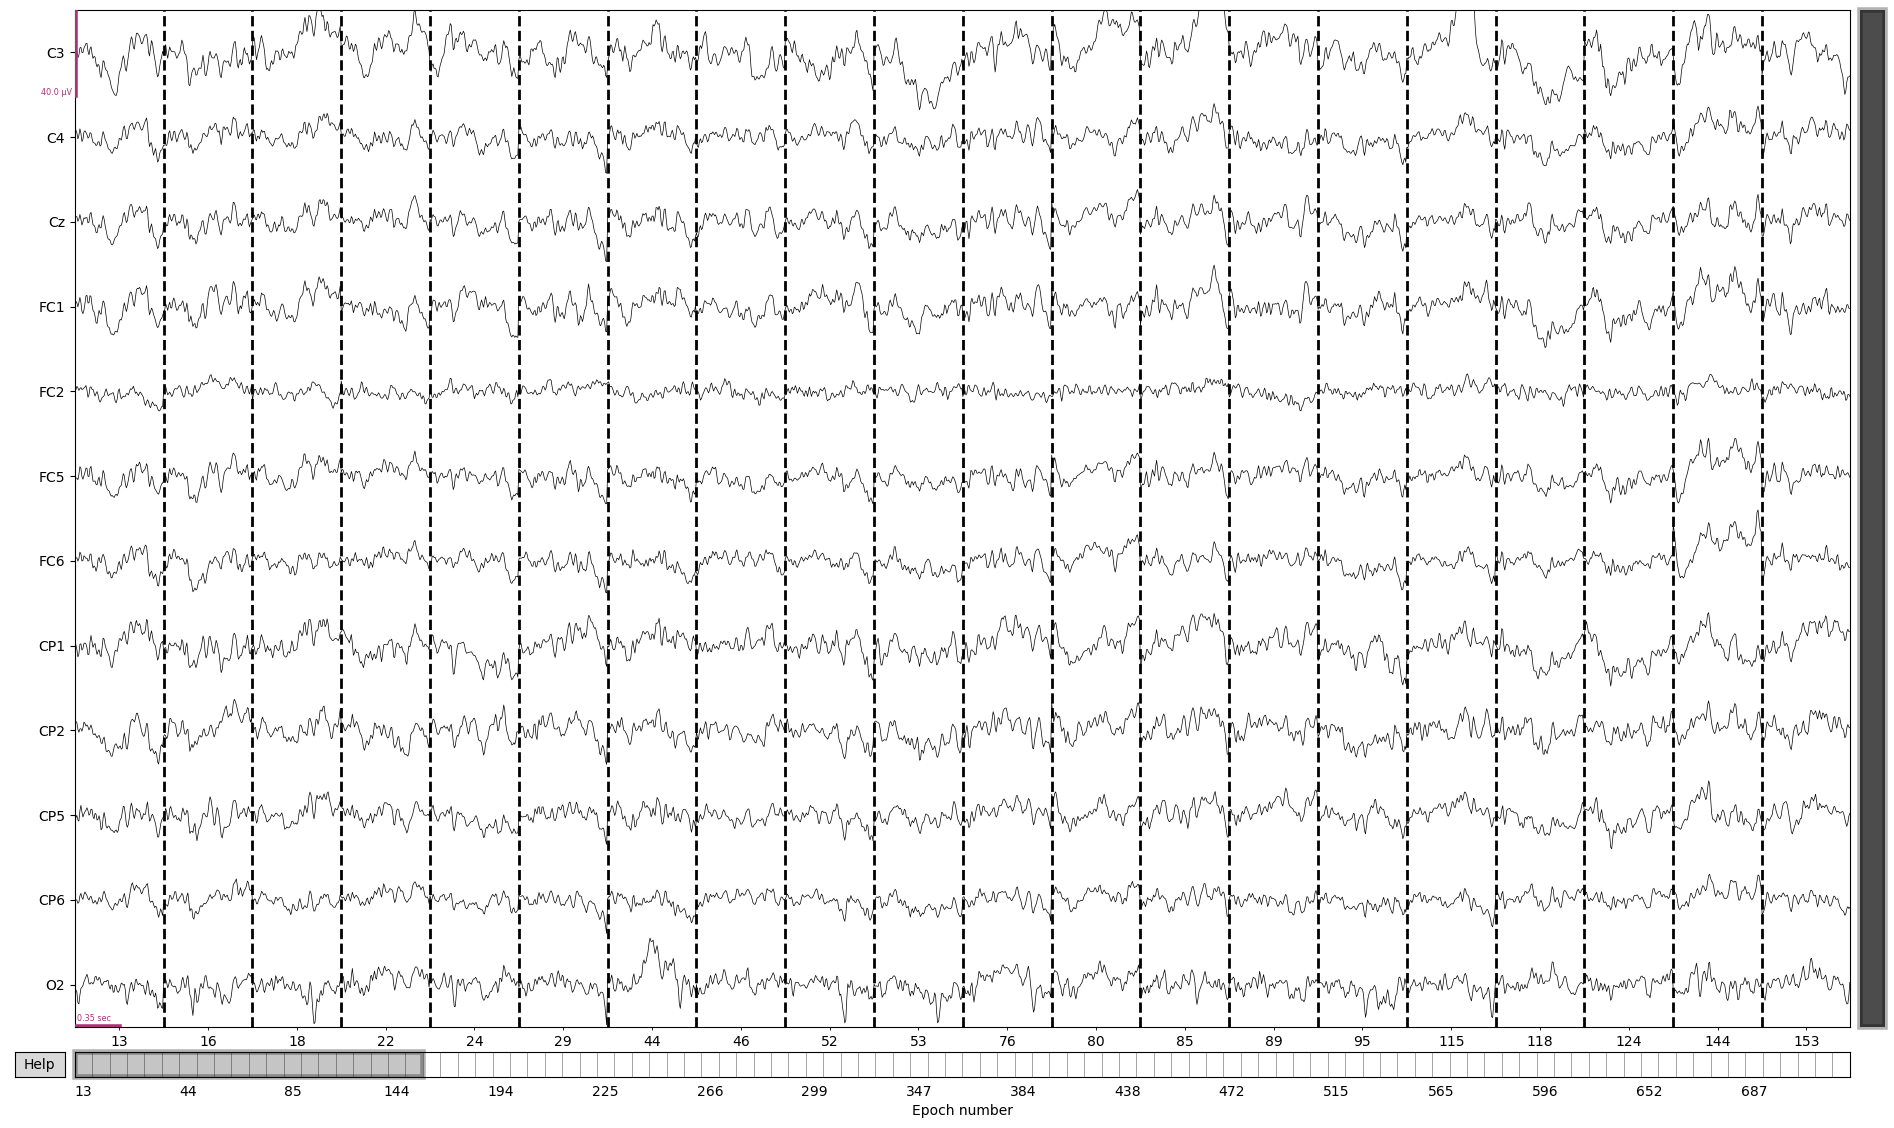

Dropped 8 epochs: 42, 48, 73, 74, 78, 84, 87, 96
The following epochs were marked as bad and are dropped:
[299, 347, 526, 531, 565, 596, 628, 687]
Channels marked as bad:
none


In [25]:
epochs['Target Trial'].plot()

In [26]:
fig, ax = plt.subplots(3,2)

epochs['Target Trial'].plot_image(picks='eeg', combine='mean',axes=ax[:,0],title="Target")
epochs['Standard Trial'].plot_image(picks='eeg', combine='mean',axes=ax[:,1],title="Standard")

plt.show()


Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"
Not setting metadata
585 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


### Plot evoked data

No projector specified for this dataset. Please consider the method self.add_proj.


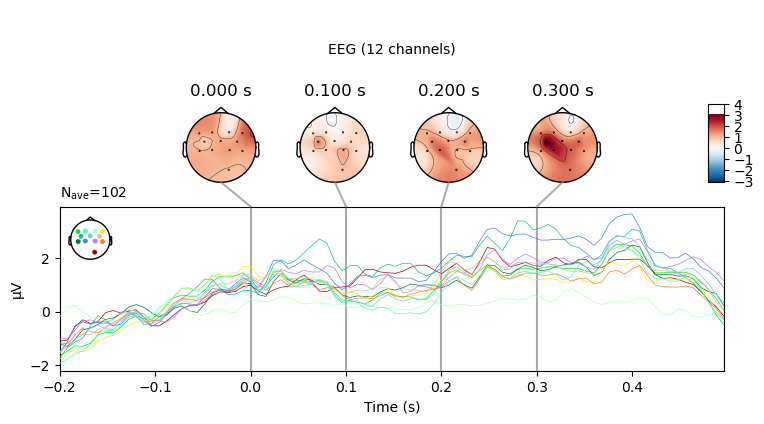

In [27]:
par_picks = ['CP1','CP2'] # to plot only parietal

odd_evoked =  epochs['Target Trial'].average()
stand_evoked =  epochs['Standard Trial'].average()


odd_evoked.plot_joint(picks='eeg',times=[0,0.1,0.2,0.3])




In [28]:
fig, ax = plt.subplots(2)



P300_window = [0.25,0.4]
par_picks = ['CP1','CP2'] # to plot only parietal


odd_evoked.plot(gfp=True,
    highlight=P300_window,axes=ax[0],titles='odd')

stand_evoked.plot(gfp=True,
    highlight=P300_window,axes=ax[1],titles='standard')

plt.show()

In [29]:
mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),combine='mean',show_sensors= True,vlines= [0.3] )

combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 2 Axes>]

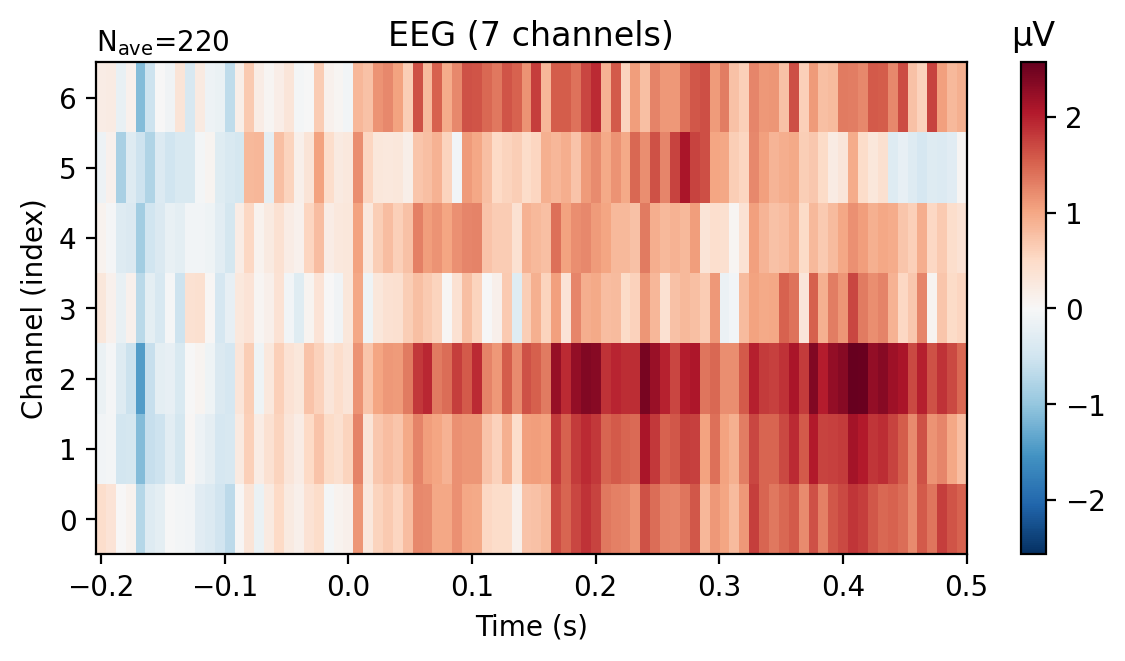

In [107]:
stand_evoked.plot_image()

In [15]:
# Each electrode indvidually 

mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked),axes='topo',vlines=[0,0.3])

[<Figure size 1800x1147 with 13 Axes>]

In [116]:
# Each electrode indvidually 

odd_evoked_ica =  epochs_ica['Target Trial'].average()
stand_evoked_ica =  epochs_ica['Standard Trial'].average()


mne.viz.plot_compare_evokeds(dict(stand=stand_evoked_ica, odd=odd_evoked_ica),axes='topo',vlines=[0,0.3])

[<Figure size 3584x1892 with 8 Axes>]

In [30]:
Difference_wave = mne.combine_evoked([odd_evoked,stand_evoked],weights=[1,-1])

In [31]:
mne.viz.plot_compare_evokeds(dict(stand=stand_evoked, odd=odd_evoked, difference=Difference_wave),axes='topo',vlines=[0,0.3])

[<Figure size 1800x1147 with 13 Axes>]

In [112]:
mne.viz.plot_compare_evokeds(dict(stand=stand_evoked_ica, odd=odd_evoked_ica,difference=Difference_wave_ica),combine='mean',show_sensors= True,vlines= [0.3] )

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


[<Figure size 1600x1200 with 2 Axes>]

In [32]:
mne.viz.plot_compare_evokeds(dict(stand=stand_evoked_ica, odd=odd_evoked_ica),combine='mean',show_sensors= True,vlines= [0.3] )

NameError: name 'stand_evoked_ica' is not defined

In [49]:
evokeds = dict (target=list(epochs['Target Trial'].iter_evoked()),standard=list(epochs['Standard Trial'].iter_evoked()))

In [50]:
mne.viz.plot_compare_evokeds(evokeds,combine='mean',show_sensors= True,vlines= [0.3] )

combining channels using "mean"
combining channels using "mean"


[<Figure size 800x600 with 2 Axes>]